In [25]:
pip install ortools

  Using cached absl_py-1.0.0-py3-none-any.whl (126 kB)



You should consider upgrading via the 'C:\Users\Nayan\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [26]:
pip install gmplot

You should consider upgrading via the 'C:\Users\Nayan\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [19]:
pip install psycopg2

  Using cached psycopg2-2.9.3-cp310-cp310-win_amd64.whl (1.2 MB)



You should consider upgrading via the 'C:\Users\Nayan\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [14]:
#%matplotlib inline
import csv
import math
import random
from matplotlib import pyplot as plt

In [7]:
def retrieveData():
    data = list(csv.reader(open('datafile.csv')))
    for i in data:
        i[0] = float(i[0])
        i[1] = float(i[1])
    lattitude = [i[0] for i in data]
    longitude = [i[1] for i in data]
    coordinates = [[lattitude[i], longitude[i]] for i in range(len(data))]
    places = [i[2] for i in data]
    return coordinates, places

def retrievePreviousData():
    data = list(csv.reader(open('prevTour.csv')))
    return data

In [29]:
class SolveTSPUsingACO:
    class Edge:
        def __init__(self, a, b, weight, initial_pheromone):
            self.a = a
            self.b = b
            self.weight = weight
            self.pheromone = initial_pheromone

    class Ant:
        def __init__(self, alpha, beta, num_nodes, edges):
            self.alpha = alpha
            self.beta = beta
            self.num_nodes = num_nodes
            self.edges = edges
            self.tour = None
            self.distance = 0.0

        def _select_node(self):
            roulette_wheel = 0.0
            unvisited_nodes = [node for node in range(self.num_nodes) if node not in self.tour]
            heuristic_total = 0.0
            for unvisited_node in unvisited_nodes:
                heuristic_total += self.edges[self.tour[-1]][unvisited_node].weight
            for unvisited_node in unvisited_nodes:
                roulette_wheel += pow(self.edges[self.tour[-1]][unvisited_node].pheromone, self.alpha) * \
                                  pow((heuristic_total / self.edges[self.tour[-1]][unvisited_node].weight), self.beta)
            random_value = random.uniform(0.0, roulette_wheel)
            wheel_position = 0.0
            for unvisited_node in unvisited_nodes:
                wheel_position += pow(self.edges[self.tour[-1]][unvisited_node].pheromone, self.alpha) * \
                                  pow((heuristic_total / self.edges[self.tour[-1]][unvisited_node].weight), self.beta)
                if wheel_position >= random_value:
                    return unvisited_node

        def find_tour(self):
            self.tour = [random.randint(0, self.num_nodes - 1)]
            while len(self.tour) < self.num_nodes:
                self.tour.append(self._select_node())
            return self.tour

        def get_distance(self):
            self.distance = 0.0
            for i in range(self.num_nodes):
                self.distance += self.edges[self.tour[i]][self.tour[(i + 1) % self.num_nodes]].weight
            return self.distance

    def __init__(self, mode='Ant Colony System', colony_size=10, elitist_weight=1.0, min_scaling_factor=0.001, alpha=1.0, beta=3.0,
                 rho=0.1, pheromone_deposit_weight=1.0, initial_pheromone=1.0, steps=100, nodes=None, labels=None, previous_path=None):
        self.mode = mode
        self.colony_size = colony_size
        self.elitist_weight = elitist_weight
        self.min_scaling_factor = min_scaling_factor
        self.rho = rho
        self.pheromone_deposit_weight = pheromone_deposit_weight
        self.steps = steps
        self.num_nodes = len(nodes)
        self.nodes = nodes
        if labels is not None:
            self.labels = labels
        else:
            self.labels = range(1, self.num_nodes + 1)
        self.edges = [[None] * self.num_nodes for _ in range(self.num_nodes)]
        for i in range(self.num_nodes):
            for j in range(i + 1, self.num_nodes):
                self.edges[i][j] = self.edges[j][i] = self.Edge(i, j, math.sqrt(
                    pow(self.nodes[i][0] - self.nodes[j][0], 2.0) + pow(self.nodes[i][1] - self.nodes[j][1], 2.0)),
                                                                initial_pheromone)

        
        if previous_path != None:
            for i in range(len(previous_path)):
                if (previous_path[i-1] in labels) and (previous_path[i] in labels):
                    for j in range(len(labels)):
                        if previous_path[i-1] == labels[j]:
                            for k in range(len(labels)):
                                if previous_path[i] == labels[k]:
                                    self.edges[j][k].pheromone = 2.0
                                    self.edges[k][j].pheromone = 2.0
                            
        
        #Use previous Opt - END ---------------------------------------------------
        
        
        self.ants = [self.Ant(alpha, beta, self.num_nodes, self.edges) for _ in range(self.colony_size)]
        self.global_best_tour = None
        self.global_best_distance = float("inf")

    def _add_pheromone(self, tour, distance, weight=1.0):
        pheromone_to_add = self.pheromone_deposit_weight / distance
        for i in range(self.num_nodes):
            self.edges[tour[i]][tour[(i + 1) % self.num_nodes]].pheromone += weight * pheromone_to_add

    def _acs(self):
        for step in range(self.steps):
            for ant in self.ants:
                self._add_pheromone(ant.find_tour(), ant.get_distance())
                if ant.distance < self.global_best_distance:
                    self.global_best_tour = ant.tour
                    self.global_best_distance = ant.distance
            for i in range(self.num_nodes):
                for j in range(i + 1, self.num_nodes):
                    self.edges[i][j].pheromone *= (1.0 - self.rho)
                    #print (self.edges[i][j].pheromone)
            #print ('\n \n -------------------------- \n \n')

    def _elitist(self):
        for step in range(self.steps):
            for ant in self.ants:
                self._add_pheromone(ant.find_tour(), ant.get_distance())
                if ant.distance < self.global_best_distance:
                    self.global_best_tour = ant.tour
                    self.global_best_distance = ant.distance
            self._add_pheromone(self.global_best_tour, self.global_best_distance, weight=self.elitist_weight)
            for i in range(self.num_nodes):
                for j in range(i + 1, self.num_nodes):
                    self.edges[i][j].pheromone *= (1.0 - self.rho)

    def run(self):
        if self.mode == 'Ant Colony System':
            self._acs()
        elif self.mode == 'Elitist - ACO':
            self._elitist()
        print('Route : <-> {0} <->'.format(' <-> '.join(str(self.labels[i]) for i in self.global_best_tour)))
        csv_str = [self.labels[i] for i in self.global_best_tour]
        with open("prevTour.csv",'w') as resultFile:
            wr = csv.writer(resultFile, dialect='excel')
            wr.writerow(csv_str)
        print('Distance of tour : {0}\n'.format(round(self.global_best_distance, 2)))

    def plot(self, line_width=1.5, point_radius=math.sqrt(2.5), annotation_size=15, dpi=120, save=True, name=None):
        img = plt.imread('ny-map.jpg')
        #img = plt.imread('dearborn_test1.PNG')
        fig, ax = plt.subplots()
        #x = range(300)
        ax.imshow(img, extent=[-455, 705, -455, 405])
        #ax.imshow(img, extent=[-455, 2600, -455, 1200])
        #ax.plot(x, x, '--', linewidth=5, color='firebrick')
        x = [self.nodes[i][0] for i in self.global_best_tour]
        x.append(x[0])
        y = [self.nodes[i][1] for i in self.global_best_tour]
        y.append(y[0])
        plt.plot(x, y, linewidth=line_width, color='blue')#color='firebrick')
        plt.scatter(x, y, s=math.pi * (point_radius ** 5.0), color='firebrick')
        plt.title(self.mode)
        for i in self.global_best_tour:
            plt.annotate(self.labels[i], self.nodes[i], size=annotation_size, color='navy')#size=annotation_size)
        if save:
            if name is None:
                name = '{0}_tour3.png'.format(self.mode)
            plt.savefig(name, dpi=dpi)
        plt.show()
        plt.gcf().clear()


Route : <-> Work <-> B <-> A <->  e <-> Office <->  c <-> Factory <->  a <-> Park <->  d <-> C <-> Plant <->  b <-> Home <-> Garage <->
Distance of tour : 2555.4



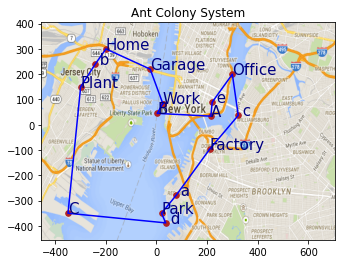

Route : <-> Plant <->  b <-> Home <-> Garage <-> Work <-> B <-> A <->  e <-> Office <->  c <-> Factory <->  a <-> Park <->  d <-> C <->
Distance of tour : 2555.4



<Figure size 432x288 with 0 Axes>

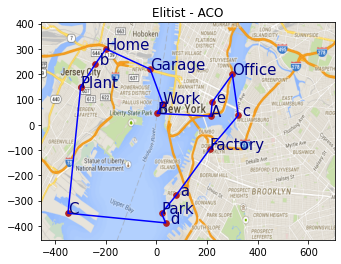

<Figure size 432x288 with 0 Axes>

In [32]:
if __name__ == '__main__':
    coordinates, places = retrieveData()
    previous_data = retrievePreviousData()
    _colony_size = 5
    _steps = 150
    _nodes = coordinates#[(random.uniform(-400, 400), random.uniform(-400, 400)) for _ in range(0, 6)]
    #_nodes = [(random.uniform(-400, 400), random.uniform(-400, 400)) for _ in range(0, 6)]
    acs = SolveTSPUsingACO(mode='Ant Colony System', colony_size=_colony_size, steps=_steps, nodes=_nodes, labels=places, previous_path=previous_data)# labels=['a', 'b', 'c', 'd', 'e', 'f'])
    acs.run()
    acs.plot()
    elitist = SolveTSPUsingACO(mode='Elitist - ACO', colony_size=_colony_size, steps=_steps, nodes=_nodes, labels=places)
    elitist.run()
    elitist.plot()


In [10]:
import csv
data = list(csv.reader(open('datafile.csv')))
for i in data:
    i[0] = float(i[0])
    i[1] = float(i[1])
lattitude = [i[0] for i in data]
longitude = [i[1] for i in data]
coordinates = [[lattitude[i], longitude[i]] for i in range(len(data))]
places = [i[2] for i in data]
print (data)
print('lattitude: ', lattitude)
print('longitude: ', longitude)
print('coordinates: ', coordinates)
print('places: ', places)

[[300.0, 200.0, 'Office'], [-300.0, 150.0, 'Plant'], [-200.0, 300.0, 'Home'], [20.0, -350.0, 'Park'], [-25.0, 220.0, 'Garage'], [25.0, 84.0, 'Work'], [210.0, -97.0, 'Factory'], [215.0, 34.0, 'A'], [3.0, 45.0, 'B'], [-350.0, -350.0, 'C'], [78.8082523072, -277.584758819, ' a'], [-241.860995569, 240.378896381, ' b'], [323.343785709, 37.0648945699, ' c'], [36.304777219, -388.104545099, ' d'], [220.411659417, 89.4733712635, ' e']]
lattitude:  [300.0, -300.0, -200.0, 20.0, -25.0, 25.0, 210.0, 215.0, 3.0, -350.0, 78.8082523072, -241.860995569, 323.343785709, 36.304777219, 220.411659417]
longitude:  [200.0, 150.0, 300.0, -350.0, 220.0, 84.0, -97.0, 34.0, 45.0, -350.0, -277.584758819, 240.378896381, 37.0648945699, -388.104545099, 89.4733712635]
coordinates:  [[300.0, 200.0], [-300.0, 150.0], [-200.0, 300.0], [20.0, -350.0], [-25.0, 220.0], [25.0, 84.0], [210.0, -97.0], [215.0, 34.0], [3.0, 45.0], [-350.0, -350.0], [78.8082523072, -277.584758819], [-241.860995569, 240.378896381], [323.343785709,

In [11]:
#Create Data Points (coordinates and locations)
import random 
A=400*random.random()

for i in range(20):
    print (400*random.uniform(-1, 1),', ', 400*random.uniform(-1, 1),',', chr(97+i))

-334.8054624256251 ,  -71.62476486838152 , a
-146.36309178832096 ,  -22.452803452057157 , b
-185.61663876909824 ,  -275.31796517692266 , c
-34.4394467133073 ,  -398.28378233568367 , d
-42.17488567798604 ,  306.0456601779734 , e
231.5077525889625 ,  -338.28013033428226 , f
43.122529021958385 ,  14.271546869708196 , g
371.2842874514293 ,  332.81659296032603 , h
-160.46897903135803 ,  228.9788650841431 , i
338.2739108158533 ,  386.7591546461535 , j
-398.5222922355512 ,  -382.85939635837127 , k
31.95219615833258 ,  141.68748837802144 , l
135.17524081455576 ,  170.67753617294903 , m
-71.62729662940572 ,  203.5976296760257 , n
139.58774157937165 ,  325.22089426066384 , o
-344.61818871363005 ,  -285.9037030161128 , p
306.9029240709063 ,  -10.96379499622051 , q
121.66024382617033 ,  353.79121220786766 , r
-43.94363903623013 ,  -14.391033381522522 , s
-116.6785684510435 ,  162.76418041129625 , t


In [16]:
from gmplot import gmplot

# Place map
gmap = gmplot.GoogleMapPlotter(42.3046, -83.2320, 13)

# Polygon
golden_gate_park_lats, golden_gate_park_lons = zip(*[
    (42.6679, -83.2082),
    (42.69, -83.25),
    (37.774797, -122.454538),
    (37.771988, -122.454018),
    (37.773646, -122.440979),
    (37.772742, -122.440797),
    (37.771096, -122.453889),
    (37.768669, -122.453518),
    (37.766227, -122.460213),
    (37.764028, -122.510347),
    (37.771269, -122.511015)
    ])
gmap.plot(golden_gate_park_lats, golden_gate_park_lons, 'cornflowerblue', edge_width=10)

# Scatter points
top_attraction_lats, top_attraction_lons = zip(*[
    (42.6779, -83.2282),
    (37.768645, -122.475328),
    (37.771478, -122.468677),
    (37.769867, -122.466102),
    (37.767187, -122.467496),
    (37.770104, -122.470436)
    ])
gmap.scatter(top_attraction_lats, top_attraction_lons, '#3B0B39', size=40, marker=False)

# Marker
hidden_gem_lat, hidden_gem_lon = 42.6679, -83.2082
gmap.marker(hidden_gem_lat, hidden_gem_lon, 'red')

# Draw
gmap.draw("my_map.html")


In [17]:
# import gmplot package
import gmplot
 
latitude_list = [ 42.6679, 42.8, 4.99 ]
longitude_list = [ -83.2, -83, -82.69 ]
 
gmap3 = gmplot.GoogleMapPlotter(42.3046, -83.2320, 13)
 
# scatter method of map object 
# scatter points on the google map
gmap3.scatter( latitude_list, longitude_list, '# FF0000',
                              size = 40, marker = False )
 
# Plot method Draw a line in
# between given coordinates
gmap3.plot(latitude_list, longitude_list, 
           'cornflowerblue', edge_width = 2.5)

# Marker
hidden_gem_lat, hidden_gem_lon = 42.6679, -83.2082
gmap3.marker(hidden_gem_lat, hidden_gem_lon, 'red')
 
gmap3.draw( "map13.html" )

C:\Users\Nayan\AppData\Local\Programs\Python\Python310\lib\site-packages\gmplot\color.py:194: UserWarning: Color '# FF0000' isn't supported.
  warnings.warn("Color '%s' isn't supported." % color)


Sequence : <- Plant -  b - Home - Garage - Work - B - A -  e - Office -  c - Factory -  a - Park -  d - C ->
Total distance travelled to complete the tour : 2555.4



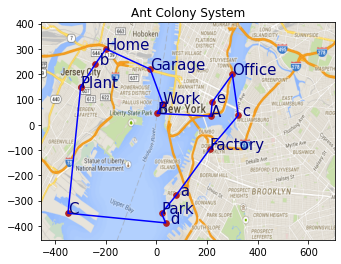

Sequence : <- Plant -  b - Home - Garage - Work - B - A -  e - Office -  c - Factory -  a - Park -  d - C ->
Total distance travelled to complete the tour : 2555.4



<Figure size 432x288 with 0 Axes>

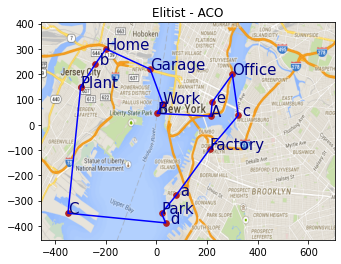

<Figure size 432x288 with 0 Axes>

In [21]:
#%matplotlib inline
import csv
import math
import random
from matplotlib import pyplot as plt


def retrieveData():
    data = list(csv.reader(open('datafile.csv')))
    for i in data:
        i[0] = float(i[0])
        i[1] = float(i[1])
    lattitude = [i[0] for i in data]
    longitude = [i[1] for i in data]
    coordinates = [[lattitude[i], longitude[i]] for i in range(len(data))]
    places = [i[2] for i in data]
    return coordinates, places

class SolveTSPUsingACO:
    class Edge:
        def __init__(self, a, b, weight, initial_pheromone):
            self.a = a
            self.b = b
            self.weight = weight
            self.pheromone = initial_pheromone

    class Ant:
        def __init__(self, alpha, beta, num_nodes, edges):
            self.alpha = alpha
            self.beta = beta
            self.num_nodes = num_nodes
            self.edges = edges
            self.tour = None
            self.distance = 0.0

        def _select_node(self):
            roulette_wheel = 0.0
            unvisited_nodes = [node for node in range(self.num_nodes) if node not in self.tour]
            heuristic_total = 0.0
            for unvisited_node in unvisited_nodes:
                heuristic_total += self.edges[self.tour[-1]][unvisited_node].weight
            for unvisited_node in unvisited_nodes:
                roulette_wheel += pow(self.edges[self.tour[-1]][unvisited_node].pheromone, self.alpha) * \
                                  pow((heuristic_total / self.edges[self.tour[-1]][unvisited_node].weight), self.beta)
            random_value = random.uniform(0.0, roulette_wheel)
            wheel_position = 0.0
            for unvisited_node in unvisited_nodes:
                wheel_position += pow(self.edges[self.tour[-1]][unvisited_node].pheromone, self.alpha) * \
                                  pow((heuristic_total / self.edges[self.tour[-1]][unvisited_node].weight), self.beta)
                if wheel_position >= random_value:
                    return unvisited_node

        def find_tour(self):
            self.tour = [random.randint(0, self.num_nodes - 1)]
            while len(self.tour) < self.num_nodes:
                self.tour.append(self._select_node())
            return self.tour

        def get_distance(self):
            self.distance = 0.0
            for i in range(self.num_nodes):
                self.distance += self.edges[self.tour[i]][self.tour[(i + 1) % self.num_nodes]].weight
            return self.distance

    def __init__(self, mode='Ant Colony System', colony_size=10, elitist_weight=1.0, min_scaling_factor=0.001, alpha=1.0, beta=3.0,
                 rho=0.1, pheromone_deposit_weight=1.0, initial_pheromone=1.0, steps=100, nodes=None, labels=None):
        self.mode = mode
        self.colony_size = colony_size
        self.elitist_weight = elitist_weight
        self.min_scaling_factor = min_scaling_factor
        self.rho = rho
        self.pheromone_deposit_weight = pheromone_deposit_weight
        self.steps = steps
        self.num_nodes = len(nodes)
        self.nodes = nodes
        if labels is not None:
            self.labels = labels
        else: #numbers labels if not assigned a name
            self.labels = range(1, self.num_nodes + 1) 
        self.edges = [[None] * self.num_nodes for _ in range(self.num_nodes)]
        for i in range(self.num_nodes):
            for j in range(i + 1, self.num_nodes):
                self.edges[i][j] = self.edges[j][i] = self.Edge(i, j, math.sqrt(
                    pow(self.nodes[i][0] - self.nodes[j][0], 2.0) + pow(self.nodes[i][1] - self.nodes[j][1], 2.0)),
                                                                initial_pheromone)
        self.ants = [self.Ant(alpha, beta, self.num_nodes, self.edges) for _ in range(self.colony_size)]
        self.global_best_tour = None
        self.global_best_distance = float("inf")

    def _add_pheromone(self, tour, distance, weight=1.0):
        pheromone_to_add = self.pheromone_deposit_weight / distance
        for i in range(self.num_nodes):
            self.edges[tour[i]][tour[(i + 1) % self.num_nodes]].pheromone += weight * pheromone_to_add

    def _acs(self):
        for step in range(self.steps):
            for ant in self.ants:
                self._add_pheromone(ant.find_tour(), ant.get_distance())
                if ant.distance < self.global_best_distance:
                    self.global_best_tour = ant.tour
                    self.global_best_distance = ant.distance
            for i in range(self.num_nodes):
                for j in range(i + 1, self.num_nodes):
                    self.edges[i][j].pheromone *= (1.0 - self.rho)

    def _elitist(self):
        for step in range(self.steps):
            for ant in self.ants:
                self._add_pheromone(ant.find_tour(), ant.get_distance())
                if ant.distance < self.global_best_distance:
                    self.global_best_tour = ant.tour
                    self.global_best_distance = ant.distance
            self._add_pheromone(self.global_best_tour, self.global_best_distance, weight=self.elitist_weight)
            for i in range(self.num_nodes):
                for j in range(i + 1, self.num_nodes):
                    self.edges[i][j].pheromone *= (1.0 - self.rho)
                    print (str(self.edges[i][j]))

    def _max_min(self):
        for step in range(self.steps):
            iteration_best_tour = None
            iteration_best_distance = float("inf")
            for ant in self.ants:
                ant.find_tour()
                if ant.get_distance() < iteration_best_distance:
                    iteration_best_tour = ant.tour
                    iteration_best_distance = ant.distance
            if float(step + 1) / float(self.steps) <= 0.75:
                self._add_pheromone(iteration_best_tour, iteration_best_distance)
                max_pheromone = self.pheromone_deposit_weight / iteration_best_distance
            else:
                if iteration_best_distance < self.global_best_distance:
                    self.global_best_tour = iteration_best_tour
                    self.global_best_distance = iteration_best_distance
                self._add_pheromone(self.global_best_tour, self.global_best_distance)
                max_pheromone = self.pheromone_deposit_weight / self.global_best_distance
            min_pheromone = max_pheromone * self.min_scaling_factor
            for i in range(self.num_nodes):
                for j in range(i + 1, self.num_nodes):
                    self.edges[i][j].pheromone *= (1.0 - self.rho)
                    if self.edges[i][j].pheromone > max_pheromone:
                        self.edges[i][j].pheromone = max_pheromone
                    elif self.edges[i][j].pheromone < min_pheromone:
                        self.edges[i][j].pheromone = min_pheromone

    def run(self):
        #print('Started : {0}'.format(self.mode))
        if self.mode == 'Ant Colony System':
            self._acs()
        elif self.mode == 'Elitist - ACO':
            self._elitist()
        print('Sequence : <- {0} ->'.format(' - '.join(str(self.labels[i]) for i in self.global_best_tour)))
        print('Total distance travelled to complete the tour : {0}\n'.format(round(self.global_best_distance, 2)))

    def plot(self, line_width=1.5, point_radius=math.sqrt(2.5), annotation_size=15, dpi=120, save=True, name=None):
        img = plt.imread('ny-map.jpg')
        #img = plt.imread('dearborn_test1.PNG')
        fig, ax = plt.subplots()
        #x = range(300)
        ax.imshow(img, extent=[-455, 705, -455, 405])
        x = [self.nodes[i][0] for i in self.global_best_tour]
        x.append(x[0])
        y = [self.nodes[i][1] for i in self.global_best_tour]
        y.append(y[0])
        plt.plot(x, y, linewidth=line_width, color='blue')#color='firebrick')
        plt.scatter(x, y, s=math.pi * (point_radius ** 5.0), color='firebrick')
        plt.title(self.mode)
        for i in self.global_best_tour:
            plt.annotate(self.labels[i], self.nodes[i], size=annotation_size, color='navy')#size=annotation_size)
        if save:
            if name is None:
                name = '{0}_tour.png'.format(self.mode)
            plt.savefig(name, dpi=dpi)
        plt.show()
        plt.gcf().clear()


if __name__ == '__main__':
    coordinates, places = retrieveData()
    _colony_size = 5
    _steps = 150
    _nodes = coordinates#[(random.uniform(-400, 400), random.uniform(-400, 400)) for _ in range(0, 6)]
    #_nodes = [(random.uniform(-400, 400), random.uniform(-400, 400)) for _ in range(0, 6)]
    acs = SolveTSPUsingACO(mode='Ant Colony System', colony_size=_colony_size, steps=_steps, nodes=_nodes, labels=places)# labels=['a', 'b', 'c', 'd', 'e', 'f'])
    acs.run()
    acs.plot()
    elitist = SolveTSPUsingACO(mode='Elitist - ACO', colony_size=_colony_size, steps=_steps, nodes=_nodes, labels=places)
    elitist.run()
    elitist.plot()


Sequence : <-> Plant <->  b <-> Home <-> Garage <-> Work <-> B <-> A <->  e <-> Office <->  c <-> Factory <->  a <-> Park <->  d <-> C <->
Total distance travelled to complete the tour : 2555.4



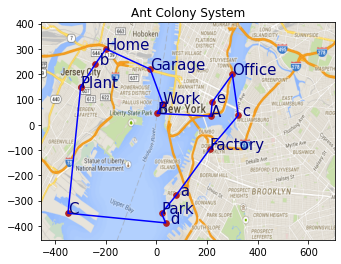

Sequence : <-> Garage <-> Work <-> B <-> A <->  e <-> Office <->  c <-> Factory <->  a <-> Park <->  d <-> C <-> Plant <->  b <-> Home <->
Total distance travelled to complete the tour : 2555.4



<Figure size 432x288 with 0 Axes>

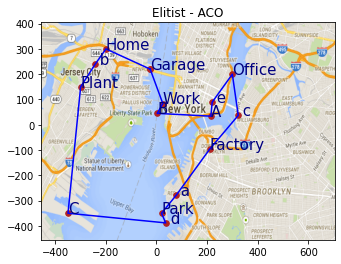

<Figure size 432x288 with 0 Axes>

In [28]:
#%matplotlib inline
import csv
import math
import random
from matplotlib import pyplot as plt


def retrieveData():
    data = list(csv.reader(open('datafile.csv')))
    for i in data:
        i[0] = float(i[0])
        i[1] = float(i[1])
    lattitude = [i[0] for i in data]
    longitude = [i[1] for i in data]
    coordinates = [[lattitude[i], longitude[i]] for i in range(len(data))]
    places = [i[2] for i in data]
    return coordinates, places

class SolveTSPUsingACO:
    class Edge:
        def __init__(self, a, b, weight, initial_pheromone):
            self.a = a
            self.b = b
            self.weight = weight
            self.pheromone = initial_pheromone

    class Ant:
        def __init__(self, alpha, beta, num_nodes, edges):
            self.alpha = alpha
            self.beta = beta
            self.num_nodes = num_nodes
            self.edges = edges
            self.tour = None
            self.distance = 0.0

        def _select_node(self):
            roulette_wheel = 0.0
            unvisited_nodes = [node for node in range(self.num_nodes) if node not in self.tour]
            heuristic_total = 0.0
            for unvisited_node in unvisited_nodes:
                heuristic_total += self.edges[self.tour[-1]][unvisited_node].weight
            for unvisited_node in unvisited_nodes:
                roulette_wheel += pow(self.edges[self.tour[-1]][unvisited_node].pheromone, self.alpha) * \
                                  pow((heuristic_total / self.edges[self.tour[-1]][unvisited_node].weight), self.beta)
            random_value = random.uniform(0.0, roulette_wheel)
            wheel_position = 0.0
            for unvisited_node in unvisited_nodes:
                wheel_position += pow(self.edges[self.tour[-1]][unvisited_node].pheromone, self.alpha) * \
                                  pow((heuristic_total / self.edges[self.tour[-1]][unvisited_node].weight), self.beta)
                if wheel_position >= random_value:
                    return unvisited_node

        def find_tour(self):
            self.tour = [random.randint(0, self.num_nodes - 1)]
            while len(self.tour) < self.num_nodes:
                self.tour.append(self._select_node())
            return self.tour

        def get_distance(self):
            self.distance = 0.0
            for i in range(self.num_nodes):
                self.distance += self.edges[self.tour[i]][self.tour[(i + 1) % self.num_nodes]].weight
            return self.distance

    # step size = 200
    def __init__(self, mode='Ant Colony System', colony_size=10, elitist_weight=1.0, min_scaling_factor=0.001, alpha=1.0, beta=3.0,
                 rho=0.1, pheromone_deposit_weight=1.0, initial_pheromone=1.0, steps=200, nodes=None, labels=None, previous_path=None):
        self.mode = mode
        self.colony_size = colony_size
        self.elitist_weight = elitist_weight
        self.min_scaling_factor = min_scaling_factor
        self.rho = rho
        self.pheromone_deposit_weight = pheromone_deposit_weight
        self.steps = steps
        self.num_nodes = len(nodes)
        self.nodes = nodes
        if labels is not None:
            self.labels = labels
        else:
            self.labels = range(1, self.num_nodes + 1)
        self.edges = [[None] * self.num_nodes for _ in range(self.num_nodes)]
        for i in range(self.num_nodes):
            for j in range(i + 1, self.num_nodes):
                self.edges[i][j] = self.edges[j][i] = self.Edge(i, j, math.sqrt(
                    pow(self.nodes[i][0] - self.nodes[j][0], 2.0) + pow(self.nodes[i][1] - self.nodes[j][1], 2.0)),
                                                                initial_pheromone)
        self.ants = [self.Ant(alpha, beta, self.num_nodes, self.edges) for _ in range(self.colony_size)]
        self.global_best_tour = None
        self.global_best_distance = float("inf")

    def _add_pheromone(self, tour, distance, weight=1.0):
        pheromone_to_add = self.pheromone_deposit_weight / distance
        for i in range(self.num_nodes):
            self.edges[tour[i]][tour[(i + 1) % self.num_nodes]].pheromone += weight * pheromone_to_add

    def _acs(self):
        for step in range(self.steps):
            for ant in self.ants:
                self._add_pheromone(ant.find_tour(), ant.get_distance())
                if ant.distance < self.global_best_distance:
                    self.global_best_tour = ant.tour
                    self.global_best_distance = ant.distance
            for i in range(self.num_nodes):
                for j in range(i + 1, self.num_nodes):
                    self.edges[i][j].pheromone *= (1.0 - self.rho)
                    #print (self.edges[i][j].pheromone)
            #print ('\n \n -------------------------- \n \n')

    def _elitist(self):
        for step in range(self.steps):
            for ant in self.ants:
                self._add_pheromone(ant.find_tour(), ant.get_distance())
                if ant.distance < self.global_best_distance:
                    self.global_best_tour = ant.tour
                    self.global_best_distance = ant.distance
            self._add_pheromone(self.global_best_tour, self.global_best_distance, weight=self.elitist_weight)
            for i in range(self.num_nodes):
                for j in range(i + 1, self.num_nodes):
                    self.edges[i][j].pheromone *= (1.0 - self.rho)

    def run(self):
        #print('Started : {0}'.format(self.mode))
        if self.mode == 'Ant Colony System':
            self._acs()
        elif self.mode == 'Elitist - ACO':
            self._elitist()
        print('Sequence : <-> {0} <->'.format(' <-> '.join(str(self.labels[i]) for i in self.global_best_tour)))
        csv_str = [self.labels[i] for i in self.global_best_tour]
        with open("prevTour.csv",'w') as resultFile:
            wr = csv.writer(resultFile, dialect='excel')
            wr.writerow(csv_str)

        print('Total distance travelled to complete the tour : {0}\n'.format(round(self.global_best_distance, 2)))

    def plot(self, line_width=1.5, point_radius=math.sqrt(2.5), annotation_size=15, dpi=120, save=True, name=None):
        img = plt.imread('ny-map.jpg')
        fig, ax = plt.subplots()
        ax.imshow(img, extent=[-455, 705, -455, 405])
        x = [self.nodes[i][0] for i in self.global_best_tour]
        x.append(x[0])
        y = [self.nodes[i][1] for i in self.global_best_tour]
        y.append(y[0])
        plt.plot(x, y, linewidth=line_width, color='blue')#color='firebrick')
        plt.scatter(x, y, s=math.pi * (point_radius ** 5.0), color='firebrick')
        plt.title(self.mode)
        for i in self.global_best_tour:
            plt.annotate(self.labels[i], self.nodes[i], size=annotation_size, color='navy')#size=annotation_size)
        if save:
            if name is None:
                name = '{0}_tour.png'.format(self.mode)
            plt.savefig(name, dpi=dpi)
        plt.show()
        plt.gcf().clear()


if __name__ == '__main__':
    coordinates, places = retrieveData()
    _colony_size = 5
    _steps = 150
    _nodes = coordinates#[(random.uniform(-400, 400), random.uniform(-400, 400)) for _ in range(0, 6)]
    #_nodes = [(random.uniform(-400, 400), random.uniform(-400, 400)) for _ in range(0, 6)]
    acs = SolveTSPUsingACO(mode='Ant Colony System', colony_size=_colony_size, steps=_steps, nodes=_nodes, labels=places)# labels=['a', 'b', 'c', 'd', 'e', 'f'])
    acs.run()
    acs.plot()
    elitist = SolveTSPUsingACO(mode='Elitist - ACO', colony_size=_colony_size, steps=_steps, nodes=_nodes, labels=places)
    elitist.run()
    elitist.plot()
